In [1]:
name = "R09725049_吳延東"
timestep = 8

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c ntu-homework3  --force

  0% 0.00/890k [00:00<?, ?B/s]
100% 890k/890k [00:00<00:00, 60.5MB/s]
  0% 0.00/68.6k [00:00<?, ?B/s]
100% 68.6k/68.6k [00:00<00:00, 75.4MB/s]
  0% 0.00/890k [00:00<?, ?B/s]
100% 890k/890k [00:00<00:00, 124MB/s]


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from scipy import stats
import time

import tensorflow as tf

from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt

seed = 5566
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
def make_data(data, timestep, data_type = 'x'):
    query_dim = 2
    if data_type == 'x':
        assert data.ndim == query_dim
        return (np.array([data[i:i+timestep] for i in range(data.shape[0]-(2*timestep))]))
    elif data_type == 'y':
        assert data.ndim == query_dim
        return (np.array([data[i+timestep:i+(2*timestep)] for i in range(data.shape[0]-(2*timestep))]))
    else:
        print('incorrect data type')
        return None

In [5]:
#AMB_TEMP, CO, NO, NO2, NOx, O3, PM10, RAINFALL, RH, SO2, THC ,cos_wind, sin_wind
timestep = 8
training_x = np.load('training_x.npy')
testing_x = np.load('testing_x.npy')
training_y = np.load('training_y.npy')
# testing_y = np.load('testing_y.npy')

### Feature engineering

In [6]:
origin_x = pd.DataFrame(training_x, columns=["AMB_TEMP", "CO", "NO", "NO2", "NOx", "O3", "PM10", "RAINFALL", "RH", "SO2", "THC" ,"cos_wind", "sin_wind"])
origin_x.corr()

,AMB_TEMP,CO,NO,NO2,NOx,O3,PM10,RAINFALL,RH,SO2,THC,cos_wind,sin_wind
AMB_TEMP,1.000000,-0.105888,-0.056348,-0.068109,-0.069795,-0.054505,-0.191877,-0.021576,-0.165678,0.130234,-0.186307,-0.401986,-0.358751
CO,-0.105888,1.000000,0.686308,0.654766,0.739735,-0.322549,0.290464,-0.010486,0.140953,0.320944,0.427836,-0.074527,-0.164349
NO,-0.056348,0.686308,1.000000,0.611150,0.847738,-0.460812,0.191635,-0.033144,0.150728,0.415514,0.435657,-0.161015,-0.240147
NO2,-0.068109,0.654766,0.611150,1.000000,0.937595,-0.476967,0.391381,-0.031175,0.177500,0.548520,0.514998,-0.211901,-0.332924
NOx,-0.069795,0.739735,0.847738,0.937595,1.000000,-0.520740,0.346322,-0.035619,0.183887,0.549401,0.535290,-0.212284,-0.328384
O3,-0.054505,-0.322549,-0.460812,-0.476967,-0.520740,1.000000,0.204382,0.027663,-0.440618,-0.222907,-0.360457,0.275592,0.251246
PM10,-0.191877,0.290464,0.191635,0.391381,0.346322,0.204382,1.000000,-0.098440,-0.294820,0.524049,0.216143,0.099033,-0.000087
RAINFALL,-0.021576,-0.010486,-0.033144,-0.031175,-0.035619,0.027663,-0.098440,1.000000,0.184723,-0.097116,0.034695,-0.025348,-0.027454
RH,-0.165678,0.140953,0.150728,0.177500,0.183887,-0.440618,-0.294820,0.184723,1.000000,-0.095408,0.305009,-0.021450,-0.237606
SO2,0.130234,0.320944,0.415514,0.548520,0.549401,-0.222907,0.524049,-0.097116,-0.095408,1.000000,0.283908,-0.220422,-0.326651


1. Since NOx is highly correlated with NO and NO2, to avoid colinearlity problem, we take NOx out of the dataset.
1. cos_wind will have a nonlinear correlation with sin_wind, so we add up a multiplication feature for cos_wind and sin_wind

In [7]:
origin_x = origin_x.drop(["NOx"], axis=1)
origin_x["mix_wind"] = np.multiply(origin_x["cos_wind"], origin_x["sin_wind"])
origin_x.corr()

,AMB_TEMP,CO,NO,NO2,O3,PM10,RAINFALL,RH,SO2,THC,cos_wind,sin_wind,mix_wind
AMB_TEMP,1.000000,-0.105888,-0.056348,-0.068109,-0.054505,-0.191877,-0.021576,-0.165678,0.130234,-0.186307,-0.401986,-0.358751,-0.091259
CO,-0.105888,1.000000,0.686308,0.654766,-0.322549,0.290464,-0.010486,0.140953,0.320944,0.427836,-0.074527,-0.164349,-0.111310
NO,-0.056348,0.686308,1.000000,0.611150,-0.460812,0.191635,-0.033144,0.150728,0.415514,0.435657,-0.161015,-0.240147,-0.120522
NO2,-0.068109,0.654766,0.611150,1.000000,-0.476967,0.391381,-0.031175,0.177500,0.548520,0.514998,-0.211901,-0.332924,-0.227626
O3,-0.054505,-0.322549,-0.460812,-0.476967,1.000000,0.204382,0.027663,-0.440618,-0.222907,-0.360457,0.275592,0.251246,0.198093
PM10,-0.191877,0.290464,0.191635,0.391381,0.204382,1.000000,-0.098440,-0.294820,0.524049,0.216143,0.099033,-0.000087,0.114854
RAINFALL,-0.021576,-0.010486,-0.033144,-0.031175,0.027663,-0.098440,1.000000,0.184723,-0.097116,0.034695,-0.025348,-0.027454,-0.017712
RH,-0.165678,0.140953,0.150728,0.177500,-0.440618,-0.294820,0.184723,1.000000,-0.095408,0.305009,-0.021450,-0.237606,-0.208679
SO2,0.130234,0.320944,0.415514,0.548520,-0.222907,0.524049,-0.097116,-0.095408,1.000000,0.283908,-0.220422,-0.326651,-0.053593
THC,-0.186307,0.427836,0.435657,0.514998,-0.360457,0.216143,0.034695,0.305009,0.283908,1.000000,-0.110372,-0.271129,-0.179252


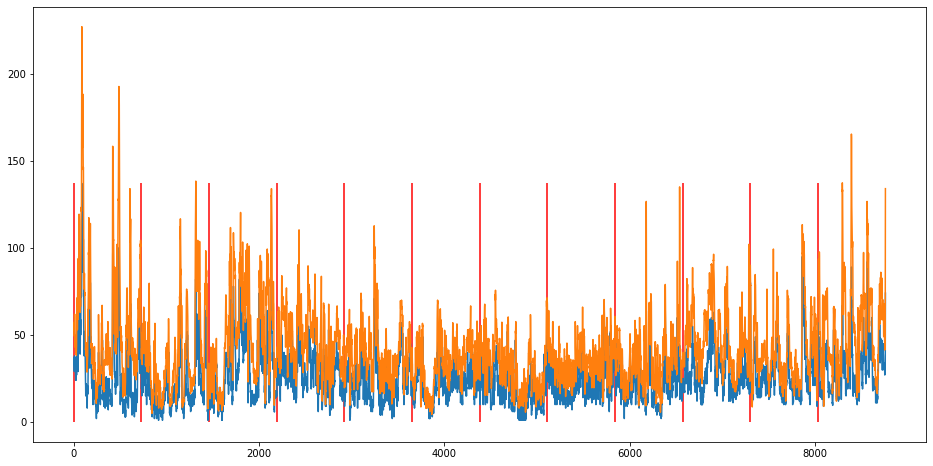

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(training_y)
plt.plot(origin_x["PM10"])
plt.vlines([i for i in range(0, training_y.shape[0], training_y.shape[0]//12)], colors="r", ls="-", ymin=0, ymax=training_y.max())
plt.show()

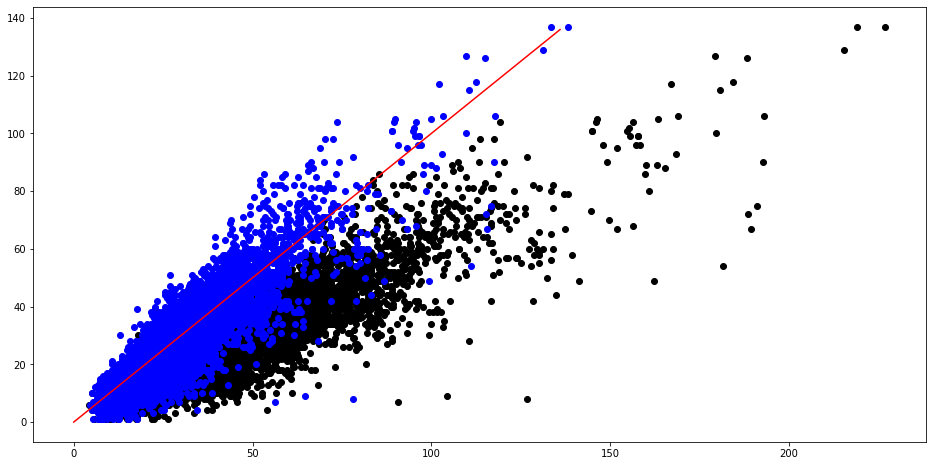

In [9]:
plt.figure(figsize=(16, 8))
plt.scatter((origin_x["PM10"]), training_y, c="black")
plt.scatter(np.add(np.multiply(origin_x["PM10"], 0.6), 2), training_y, c="b")
plt.plot(np.arange(training_y.max()), c="r")
plt.show()

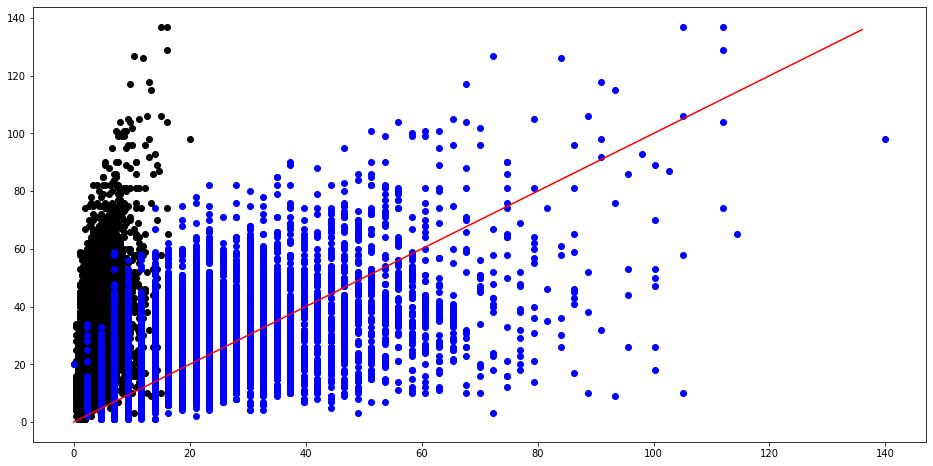

In [10]:
plt.figure(figsize=(16, 8))
plt.scatter((origin_x["SO2"]), training_y, c="black")
# plt.scatter((origin_x["SO2"]-origin_x["SO2"].min())/(origin_x["SO2"].max() - origin_x["SO2"].min())*training_y.max(), training_y, c="g")
plt.scatter(np.multiply(origin_x["SO2"], 7), training_y, c="b")
plt.plot(np.arange(training_y.max()), c="r")
plt.show()

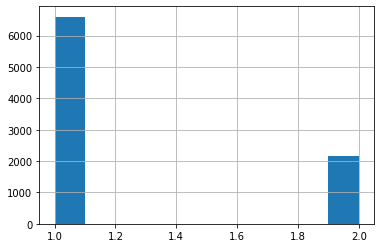

In [11]:
origin_x["THC"].hist()

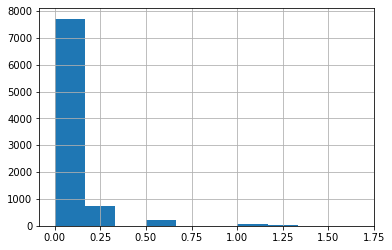

In [12]:
origin_x["CO"].hist()

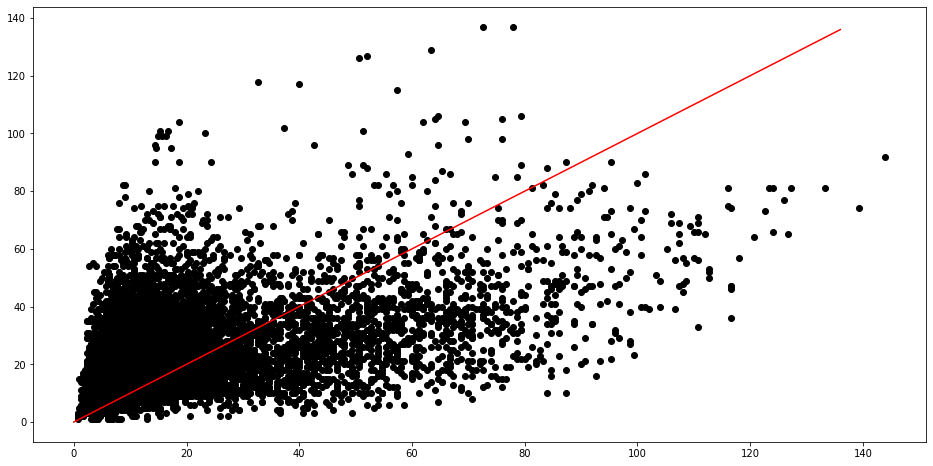

In [13]:
plt.figure(figsize=(16, 8))
plt.scatter((origin_x["NO2"]*origin_x["THC"]), training_y, c="black")
plt.plot(np.arange(training_y.max()), c="r")
plt.show()

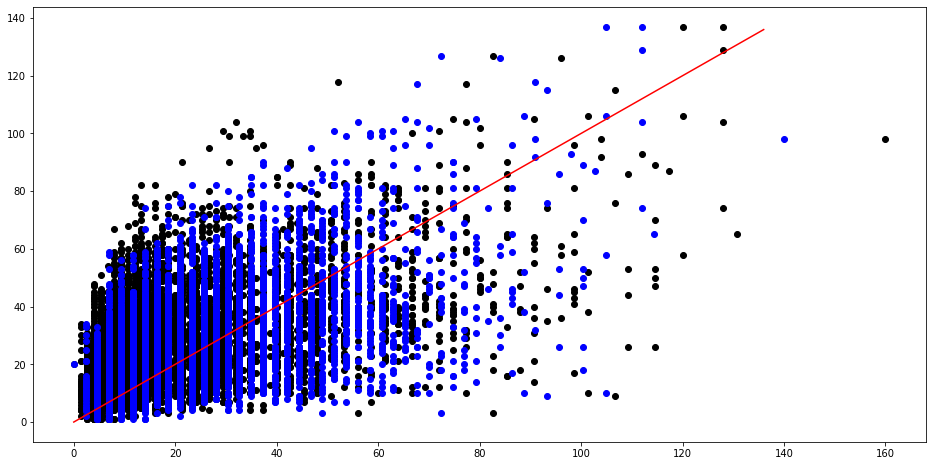

In [14]:
plt.figure(figsize=(16, 8))
plt.scatter((origin_x["SO2"]*origin_x["THC"]*4), training_y, c="black")
plt.scatter(np.multiply(origin_x["SO2"], 7), training_y, c="b")
plt.plot(np.arange(training_y.max()), c="r")
plt.show()

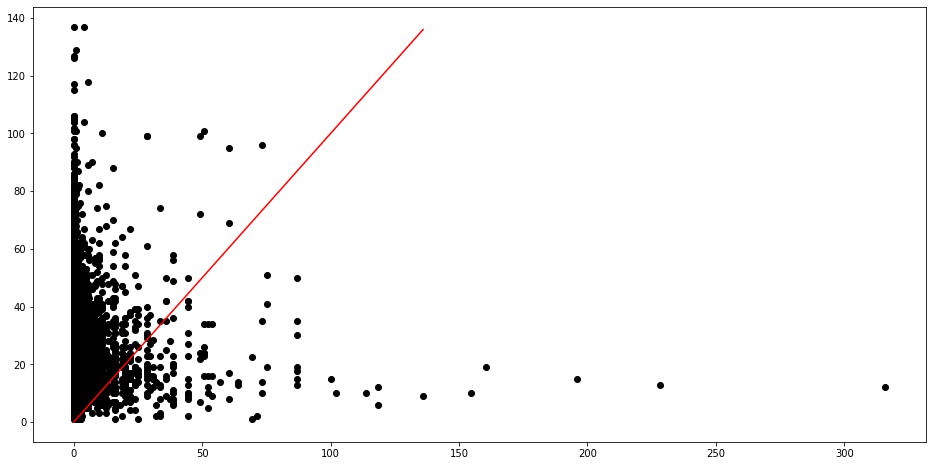

In [15]:
plt.figure(figsize=(16, 8))
plt.scatter((origin_x["cos_wind"]*origin_x["cos_wind"]*origin_x["sin_wind"]*origin_x["sin_wind"]), training_y, c="black")
plt.plot(np.arange(training_y.max()), c="r")
plt.show()

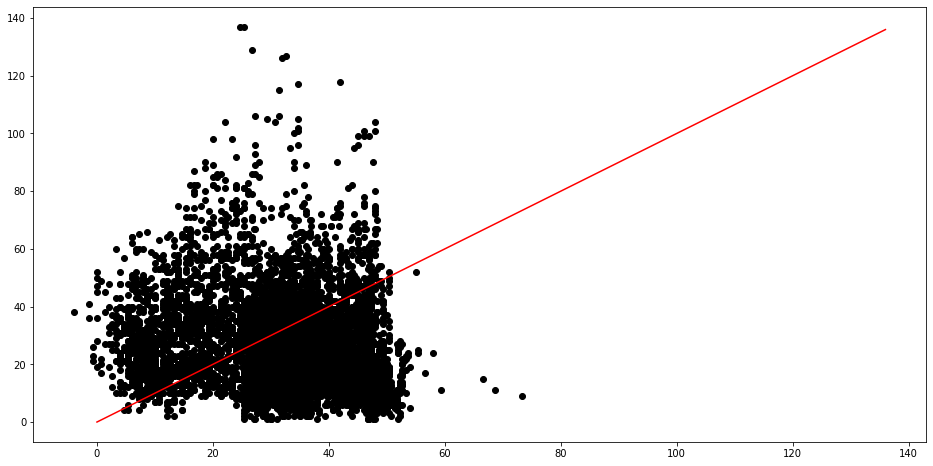

In [16]:
plt.figure(figsize=(16, 8))
plt.scatter(((origin_x["RAINFALL"]-origin_x["AMB_TEMP"])*origin_x["THC"])+60, training_y, c="black")
plt.plot(np.arange(training_y.max()), c="r")
plt.show()

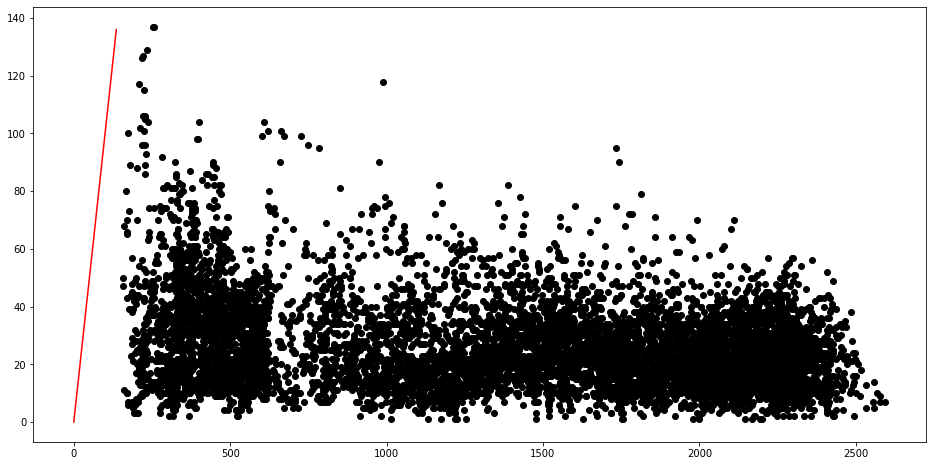

In [17]:
plt.figure(figsize=(16, 8))
# plt.scatter((origin_x["RAINFALL"]), training_y, c="b")
plt.scatter(((origin_x["AMB_TEMP"])*origin_x["RH"])/(origin_x["THC"]**2), training_y, c="black")
plt.plot(np.arange(training_y.max()), c="r")
plt.show()

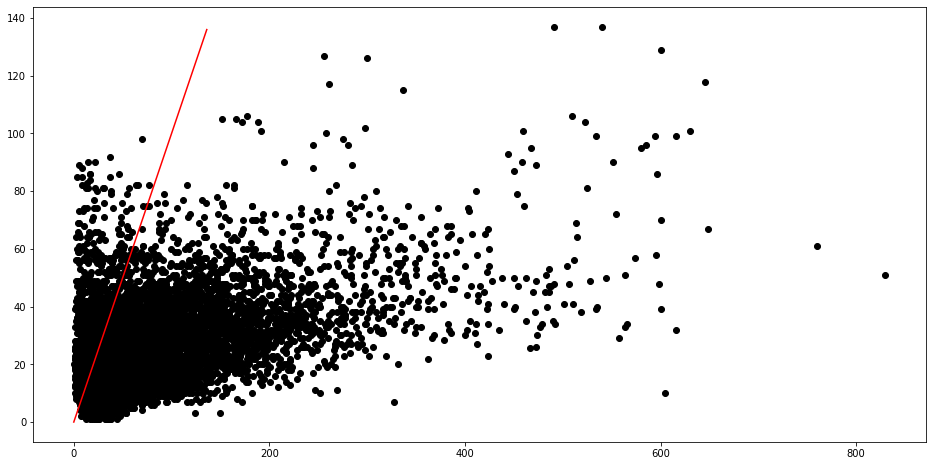

In [18]:
plt.figure(figsize=(16, 8))
# plt.scatter((origin_x["O3"]*origin_x["SO2"]*(2**origin_x["THC"])), training_y, c="black")
plt.scatter((origin_x["O3"]*origin_x["SO2"]/(origin_x["CO"]+1)), training_y, c="black")
plt.plot(np.arange(training_y.max()), c="r")
plt.show()

In [19]:
def feature_engineering(x:np.array, pm10=False):
  df = pd.DataFrame(training_x, columns=["AMB_TEMP", "CO", "NO", "NO2", "NOx", "O3", "PM10", "RAINFALL", "RH", "SO2", "THC" ,"cos_wind", "sin_wind"])
  
  df["mix_wind"] = origin_x["cos_wind"]*origin_x["cos_wind"]*origin_x["sin_wind"]*origin_x["sin_wind"]
  df["month"] = [i//(training_y.shape[0]//12)+1 for i in df.index.to_list()]
  df["PM10_shift"] = np.add(np.multiply(df["PM10"], 0.6), 2)
  df["SO2_shift"] = origin_x["SO2"]*origin_x["THC"]*4
  df["NO2xTHC"] = origin_x["NO2"]*origin_x["THC"]
  df["AMB_TEMPxRH/THC"] = ((origin_x["AMB_TEMP"])*origin_x["RH"])/(origin_x["THC"]**2)
  df["O3xSO2/CO"] = np.divide(origin_x["O3"]*origin_x["SO2"], (origin_x["CO"]+1))
  
  df = df.drop(["NOx"], axis=1)
  df = df.drop(["PM10"], axis=1)
  df = df.drop(["SO2"], axis=1)
  # print(df.head())
  if pm10:
    return np.array([[i] for i in df["PM10"]])
  return np.array(df)

In [20]:
## 結果最後發現沒有做 feature engineering 的結果比較好
training_x_shift = make_data(training_x, timestep, data_type = 'x')
testing_x_shift = make_data(testing_x, timestep, data_type = 'x')
# training_x_shift = make_data(feature_engineering(training_x, pm10=False), timestep, data_type = 'x')
# testing_x_shift = make_data(feature_engineering(testing_x, pm10=False), timestep, data_type = 'x')
print(training_x_shift.shape, testing_x_shift.shape)

training_y_shift = make_data(training_y, timestep, data_type = 'y')
print(training_y_shift.shape)

(8744, 8, 13) (8744, 8, 13)
(8744, 8, 1)


In [21]:
rnn = models.Sequential()

rnn.add(layers.Input(shape=(training_x_shift.shape[1], training_x_shift.shape[2])))
## Add a LSTM layer with 32 internal units.
## 用 softplus 比較符合我想保留 x 而且有正的 y
rnn.add(layers.LSTM(32, dropout=0.1, return_sequences=True, activation="softplus", kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3)))
rnn.add(layers.LayerNormalization(axis=-1))
# 運用 layer normalization 來處理資料散佈有極端值的問題
rnn.add(layers.LSTM(256, dropout=0.1, return_sequences=False, activation="softplus", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-2)))
rnn.add(layers.LayerNormalization(axis=-1))
rnn.add(layers.Dense(32))
rnn.add(layers.Dropout(.2))
## 最後一層輸出
rnn.add(layers.Dense(8))

In [ ]:
## record the cost of time
t0 = time.time()
# 因為 epoch 跑比較多次，所以 learning rate 調比較小
rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), loss=tf.keras.losses.MeanSquaredError())

# Model weights are saved at the end of every epoch, if it's the best seen so far.
# And early stop in 2 epochs

checkpoint_filepath = '%s.h5' %name
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True),
]

# The model weights (that are considered the best) are loaded into the model.
rnn_history = rnn.fit(
    training_x_shift, training_y_shift, epochs=500, validation_split=0.2, shuffle=True, batch_size=64, workers=8, use_multiprocessing=True, 
    callbacks=my_callbacks
    )

rnn.load_weights(checkpoint_filepath)
t1 = time.time()
print("---training finished, time cost: %d min---" %((t1-t0)/60))

Epoch 1/500
110/110 [==============================] - 41s 343ms/step - loss: 234.2921 - val_loss: 172.7928
Epoch 2/500
110/110 [==============================] - 7s 66ms/step - loss: 150.8701 - val_loss: 144.4559
Epoch 3/500
110/110 [==============================] - 7s 66ms/step - loss: 139.3823 - val_loss: 188.2772
Epoch 4/500
110/110 [==============================] - 7s 66ms/step - loss: 134.9692 - val_loss: 148.4297
Epoch 5/500
110/110 [==============================] - 7s 64ms/step - loss: 130.0090 - val_loss: 145.9429
Epoch 6/500
110/110 [==============================] - 7s 65ms/step - loss: 127.6753 - val_loss: 153.5354
Epoch 7/500
110/110 [==============================] - 7s 65ms/step - loss: 122.6451 - val_loss: 149.7421
Epoch 8/500
110/110 [==============================] - 7s 65ms/step - loss: 122.1378 - val_loss: 132.4479
Epoch 9/500
110/110 [==============================] - 7s 65ms/step - loss: 120.0112 - val_loss: 137.5618
Epoch 10/500
110/110 [======================

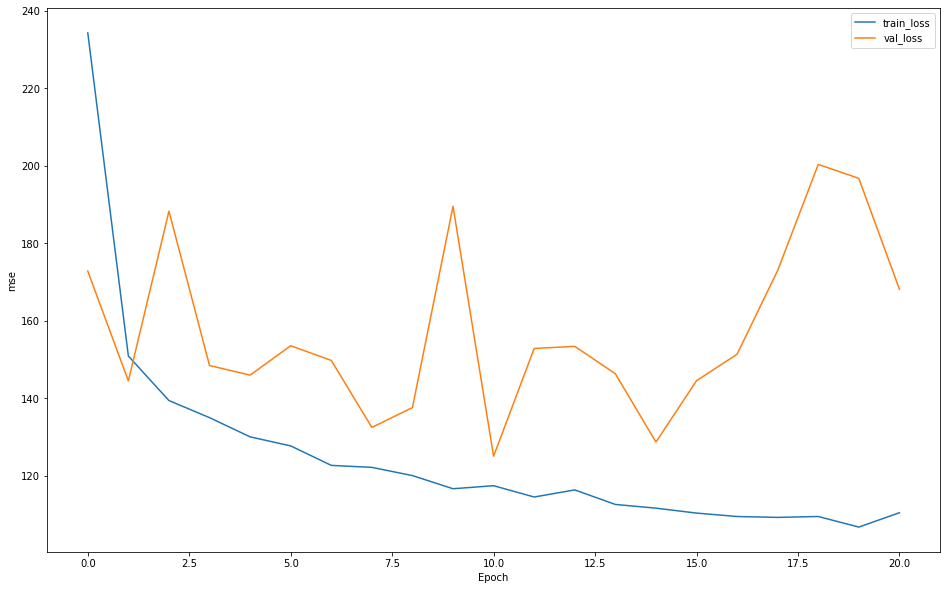

In [ ]:
## 訓練的 loss 圖
plt.figure(figsize=(16, 10))
plt.plot(rnn_history.history['loss'], label='train_loss')
plt.plot(rnn_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(loc='upper right')

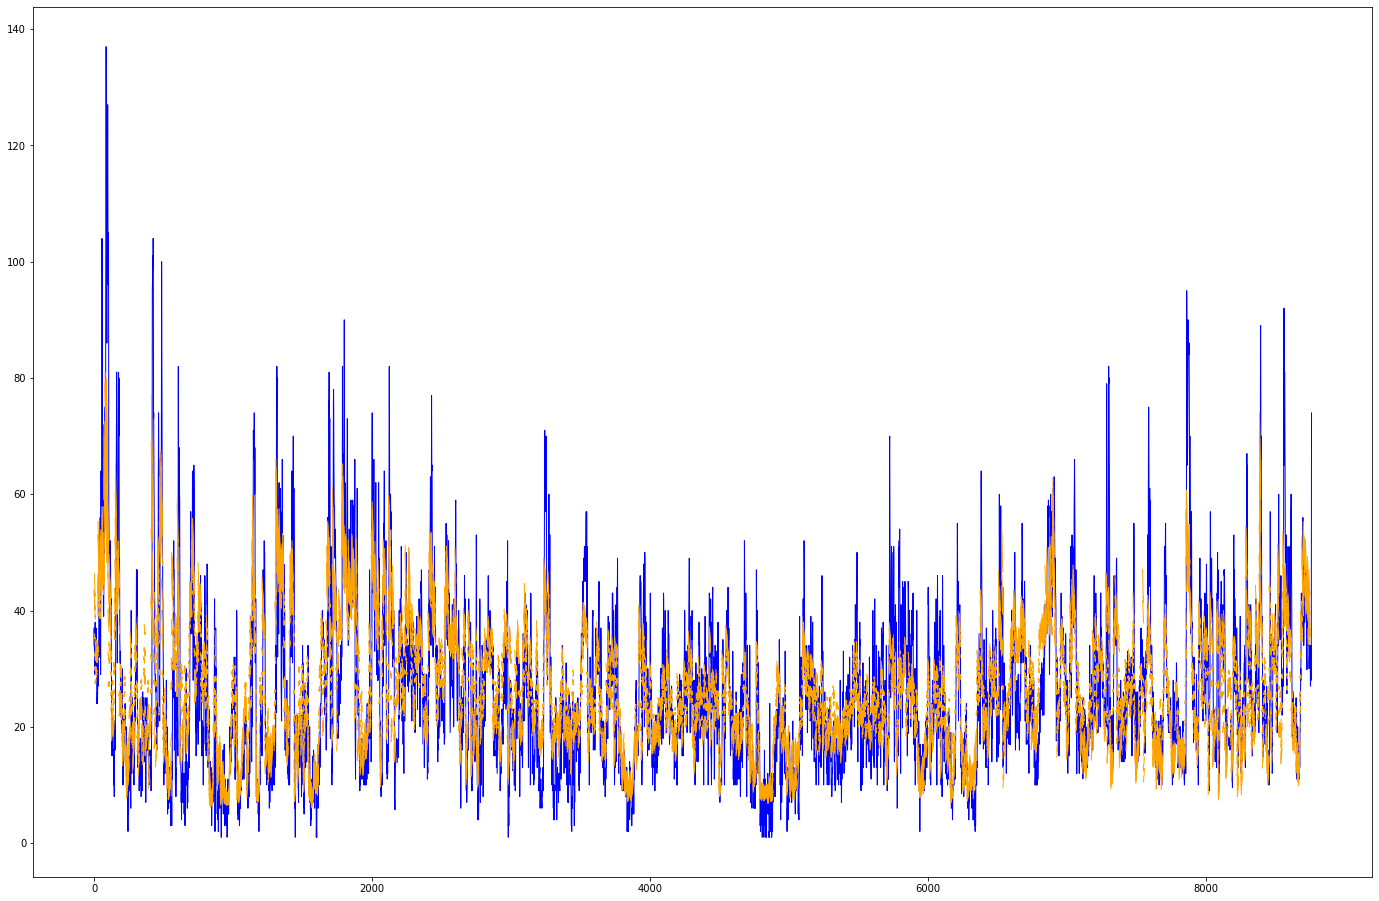

---training finished, time cost: 3 min---


In [ ]:
## 毛毛蟲圖
training_pred = rnn.predict(training_x_shift,)
plt.figure(figsize=(24, 16))
plt.plot(training_y, lw=1, c="b")
for i in range(training_pred.shape[0]):
  plt.plot([i+j for j in range(8)], training_pred[i], lw=1, c="orange")
plt.show()
t1 = time.time()
print("---training finished, time cost: %d min---" %((t1-t0)/60))

In [ ]:
pd.DataFrame(training_pred)

,0,1,2,3,4,5,6,7
0,52.097229,52.326565,51.468452,50.318329,50.415791,48.936413,48.968204,48.005890
1,50.919106,51.130371,50.295483,49.183746,49.291981,47.830029,47.881035,46.944355
2,52.113510,52.381279,51.505638,50.372562,50.470432,48.967762,49.019867,48.049847
3,47.269760,47.590355,46.898438,45.969955,46.091091,44.810619,44.948032,44.114357
4,41.275963,41.663963,41.136150,40.451286,40.605228,39.599819,39.814404,39.158829
...,...,...,...,...,...,...,...,...
8739,34.174458,34.335403,33.956982,33.372082,33.506836,32.764931,32.819424,32.401890
8740,33.898705,34.091469,33.727383,33.193031,33.311855,32.619167,32.708912,32.283104
8741,31.989227,32.197350,31.876852,31.459591,31.583002,30.983067,31.091978,30.714567
8742,26.475140,26.767776,26.617197,26.480284,26.765570,26.362066,26.568174,26.327108


In [ ]:
idx = [i+1 for i in range(8744)]
col = ["PM2.5-%s" %(i+1) for i in range(8)]
testing_pred = rnn.predict(testing_x_shift,)
pred_df = pd.DataFrame(testing_pred, index=idx, columns=col)
pred_df["INDEX"] = [i+1 for i in range(8744)]
pred_df.to_csv("%s.csv" %name, index=False)
pred_df

,PM2.5-1,PM2.5-2,PM2.5-3,PM2.5-4,PM2.5-5,PM2.5-6,PM2.5-7,PM2.5-8,INDEX
1,31.153168,30.455008,30.673231,30.704758,30.203598,29.747879,30.223986,29.744761,1
2,33.295635,32.581821,32.761505,32.671860,32.095146,31.567623,32.018726,31.483824,2
3,32.197678,31.424875,31.509558,31.544090,30.969584,30.539913,30.919748,30.391901,3
4,33.871170,32.989723,32.974045,32.977951,32.317188,31.900242,32.109802,31.538233,4
5,28.641701,28.006853,28.182394,28.343155,27.882557,27.565693,28.001188,27.595446,5
...,...,...,...,...,...,...,...,...,...
8740,31.185089,30.683775,30.815107,31.094763,30.606663,30.372437,30.672155,30.314199,8740
8741,38.891323,38.153503,37.944584,37.935516,37.120899,36.788029,36.736080,36.153599,8741
8742,44.623356,43.739639,43.297726,43.059807,41.977486,41.567062,41.212910,40.516483,8742
8743,52.719803,51.758560,51.070950,50.381279,48.939362,48.287273,47.609684,46.734821,8743


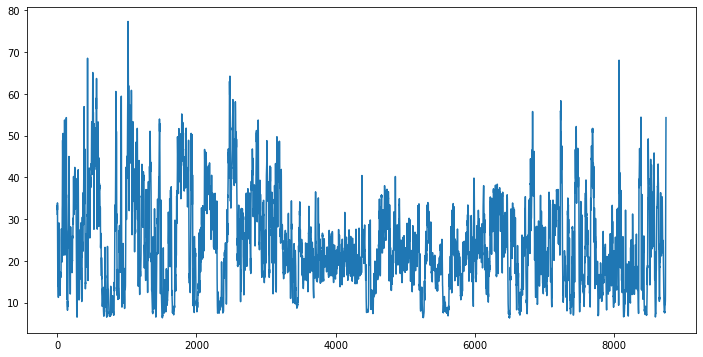

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pred_df["PM2.5-1"])

In [ ]:
! kaggle competitions submit -c ntu-homework3 -f R09725049_吳延東.csv -m "Message"

100% 706k/706k [00:00<00:00, 2.73MB/s]
Successfully submitted to NTU Homework3